Starting pitch detection...
Pitch: 151.55 Hz, Note: 51
Pitch: 141.80 Hz, Note: 49
Pitch: 130.86 Hz, Note: 48
Pitch: 130.86 Hz, Note: 48
Pitch: 131.25 Hz, Note: 48
Pitch: 131.64 Hz, Note: 48
Pitch: 134.04 Hz, Note: 48
Pitch: 136.11 Hz, Note: 49
Pitch: 139.56 Hz, Note: 49
Pitch: 140.00 Hz, Note: 49
Pitch: 139.12 Hz, Note: 49
Pitch: 138.68 Hz, Note: 49
Pitch: 138.24 Hz, Note: 49
Pitch: 139.56 Hz, Note: 49
Pitch: 140.00 Hz, Note: 49
Pitch: 139.56 Hz, Note: 49
Pitch: 138.68 Hz, Note: 49
Pitch: 138.68 Hz, Note: 49
Pitch: 139.12 Hz, Note: 49
Pitch: 138.68 Hz, Note: 49
Pitch: 137.38 Hz, Note: 49
Pitch: 137.81 Hz, Note: 49
Pitch: 137.81 Hz, Note: 49
Pitch: 138.24 Hz, Note: 49
Pitch: 137.38 Hz, Note: 49
Pitch: 138.68 Hz, Note: 49
Pitch: 139.56 Hz, Note: 49
Pitch: 139.56 Hz, Note: 49
Pitch: 138.68 Hz, Note: 49
Pitch: 138.68 Hz, Note: 49
Pitch: 139.56 Hz, Note: 49
Pitch: 139.56 Hz, Note: 49
Pitch: 138.68 Hz, Note: 49
Pitch: 140.45 Hz, Note: 49
Pitch: 143.18 Hz, Note: 50
Pitch: 140.89 Hz, Note: 49


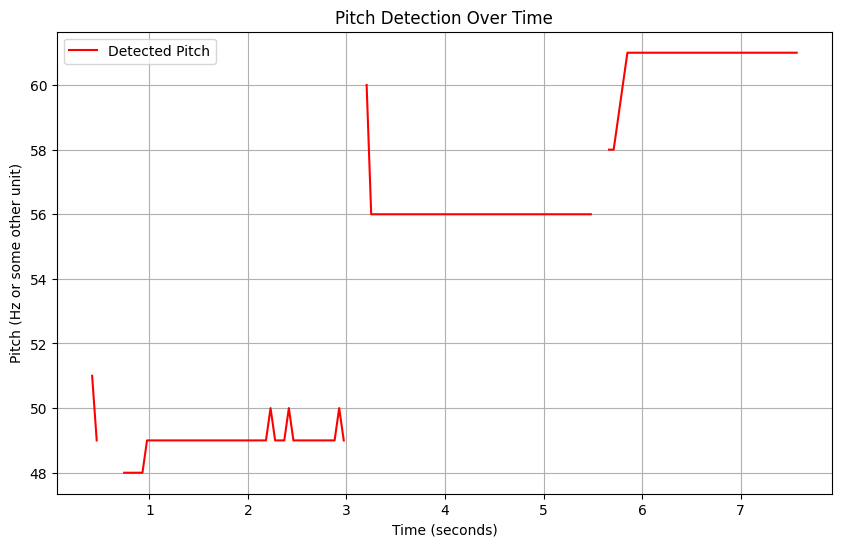

In [7]:
from pitch_detect import *
%run pitch_detect.py


import matplotlib.pyplot as plt
time_points = [i*(BUF_SIZE/SAMPLE_RATE) for i in range(len(pitches))]  
notes = [note_from_pitch(i) if i!=None else None for i in pitches]

# Plot the notes over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, notes, label="Detected Pitch", color='red')
plt.title("Pitch Detection Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Pitch (Hz or some other unit)")
plt.grid(True)
plt.legend()
plt.show()

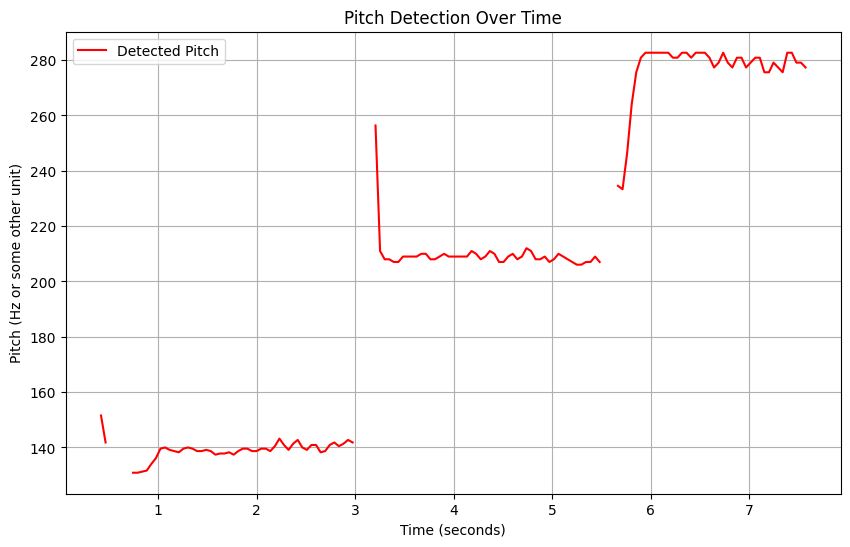

In [8]:
# Plot the notes over time
plt.figure(figsize=(10, 6))
plt.plot(time_points, pitches, label="Detected Pitch", color='red')
plt.title("Pitch Detection Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Pitch (Hz or some other unit)")
plt.grid(True)
plt.legend()
plt.show()

In [44]:
around = 3.2
buf = 10
pitch_dict = dict(zip(time_points, pitches))

req = {k:v for k,v in pitch_dict.items() if (k>(around-buf)) and (k<(around+buf))}

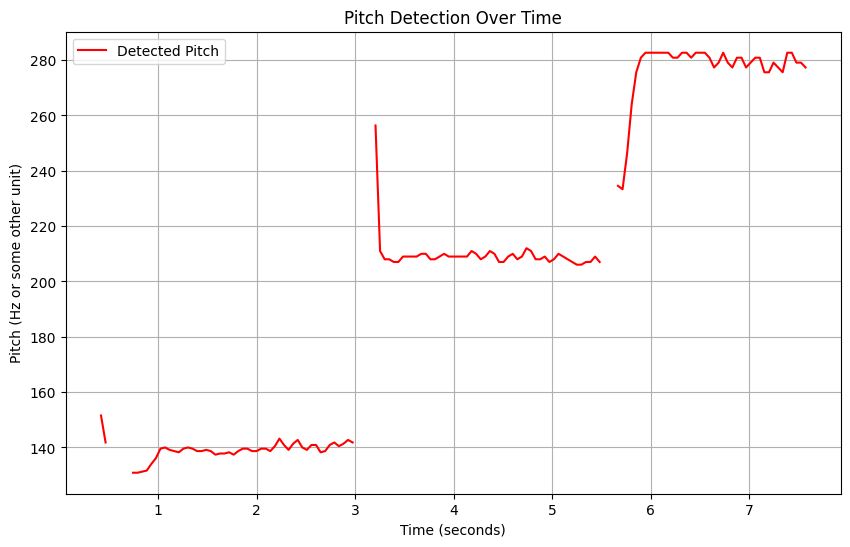

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(req.keys(), req.values(), label="Detected Pitch", color='red')
plt.title("Pitch Detection Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Pitch (Hz or some other unit)")
plt.grid(True)
plt.legend()
plt.show()